In [1]:
import sys
sys.path.append("../src/")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#reading all the files

#reading the first file
df = pd.read_csv('../src/outputs/run_history_19.csv', sep=';', index_col=0)
df_emb = pd.read_csv('../src/outputs/run_history_emb_idx_19.csv', sep=';', index_col=0)
np_emb_state = np.load('../src/outputs/emb_states_19.npy', allow_pickle=True)
np_emb_next_state = np.load('../src/outputs/next_states_19.npy', allow_pickle=True)

skeeped_files = []
#adding all the others
list1 = list(range(39, 5000, 20))
for i in tqdm.tqdm(list1):
    s1 = '../src/outputs/run_history_' + str(i) + '.csv'
    df_ = pd.read_csv(s1, sep=';', index_col=0)
    s2 = '../src/outputs/emb_states_' + str(i) + '.npy'
    np_emb_state_ = np.load(s2, allow_pickle=True)
    if np_emb_state_.shape[0] != df_.shape[0]:
        print ('skeeping file %d' %i)
        skeeped_files.append(s1)
        skeeped_files.append(s2)
    else:
        df = pd.concat([df,df_], axis=0)
        np_emb_state = np.concatenate((np_emb_state, np_emb_state_))
        
print(df.shape)
print(np_emb_state.shape)

 29%|███████████████████████▍                                                        | 73/249 [00:02<00:06, 27.80it/s]

skeeping file 1439


 81%|████████████████████████████████████████████████████████████████               | 202/249 [00:08<00:01, 27.71it/s]

skeeping file 3979


 94%|██████████████████████████████████████████████████████████████████████████▏    | 234/249 [00:09<00:00, 24.54it/s]

skeeping file 4659
skeeping file 4699


100%|███████████████████████████████████████████████████████████████████████████████| 249/249 [00:09<00:00, 25.07it/s]

(120311, 8)
(120311,)


In [3]:
df.shape

(120311, 8)

In [4]:
df[df['reward'] >= 0].head()

,episode,step,original_payload,state,action,next_state,reward,win
129,5,10,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,7,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n0x1\t#_4...,0.0,1
183,7,24,""" ) or benchmark ( 10000000,MD5 ( 1 ) ) #""","""\t )\t \t or\t benchmark\t (\t 0x989680...",9,"""\t \t )\t \t \t \t or\t \t benchmark\t \t (\t...",0.0,1
224,9,11,or pg_sleep ( __TIME__ ) --,\n\n \n ||\n \n\n pg_sleep\n\n (\n\n __TIME__\...,14,\n\n#p7D$y2\n\n#p7D$y2\n||\n#p7D$y2\n\n\n#p7D$...,0.0,1
287,12,3,a' or 'a' = 'a,a' or 'a' = 'a,12,a' or 'a' = 'a,0.0,1
298,13,11,or 1 = 1/*,or\n\t \n 0x1\n\t \n =\n\t \n 0x1/*,14,or\n\t \n#7IM6ta\n0x1\n\t \n#7IM6ta\n=\n\t \n#...,0.0,1


In [18]:

#numero de episodios ganados
n_win = df[df['reward'] >= 0].episode.nunique()

In [19]:
n_eps = df.episode.nunique()

In [20]:
print("Ratio win vs played: %.3f" %(n_win/n_eps))

Ratio win vs played: 0.302


In [21]:
df_ = df[df['episode'] == 5]

In [22]:
df['exp_reward'] = 0.0

In [23]:
# we need to estimate the discounted reward from the current state, action until the end of the episode
episodes = list(df.episode.unique())
print(len(episodes))

4920


In [29]:
discount = 0.99 #based in the PPO original paper, default discount
num_eps = 0
for ep in tqdm.tqdm(episodes):
    df_ = df[df['episode'] == 5].copy()
    df_.sort_values(by=['step'], ascending=False, inplace=True)
    cum_reward = 0.0
    j = 0
    for i,step in df_.iterrows():
        if j == 0:
            cum_reward = step.reward
        else:
            cum_reward = cum_reward + discount * step.reward
        df.at[i,'exp_reward'] = cum_reward
        j += 1

100%|████████████████████████████████████████████████████████████████████████████| 4920/4920 [00:10<00:00, 488.43it/s]


In [30]:
df[df['episode'] == 5]

,episode,step,original_payload,state,action,next_state,reward,win,exp_reward
120,5,1,or 1 = 1 /*,or 1 = 1 /*,9,\t or\t 1\t =\t 1\t /*,-0.176471,0,-0.662567
121,5,2,or 1 = 1 /*,\t or\t 1\t =\t 1\t /*,6,\t || \t 1\t =\t 1\t /*,-0.157895,0,-0.487861
122,5,3,or 1 = 1 /*,\t || \t 1\t =\t 1\t /*,14,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.049180,0,-0.331546
123,5,4,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,16,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.047619,0,-0.282857
124,5,5,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,18,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.047619,0,-0.235714
125,5,6,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,4,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.047619,0,-0.188571
126,5,7,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,12,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.047619,0,-0.141429
127,5,8,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,23,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.047619,0,-0.094286
128,5,9,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,19,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,-0.047619,0,-0.047143
129,5,10,or 1 = 1 /*,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n1\t#_4v7...,7,\t#_4v7;\n#_4v7;\n||#_4v7;\n\t#_4v7;\n0x1\t#_4...,0.000000,1,0.000000


In [31]:
df[df['episode'] == 15]

,episode,step,original_payload,state,action,next_state,reward,win,exp_reward
329,15,1,or 1 = 1,or 1 = 1,23,or 1 = 1,-0.375000,0,-0.574200
330,15,2,or 1 = 1,or 1 = 1,1,or 1 = 1,-0.375000,0,-0.287100
331,15,3,or 1 = 1,or 1 = 1,16,or 1 = 1,-0.375000,0,0.000000
332,15,4,or 1 = 1,or 1 = 1,4,or 1 = 1,-0.375000,0,-9.744243
333,15,5,or 1 = 1,or 1 = 1,3,or 1 = 1,-0.375000,0,-9.304243
334,15,6,or 1 = 1,or 1 = 1,20,or 1 = 1,-0.375000,0,-8.974243
335,15,7,or 1 = 1,or 1 = 1,22,or 1 = 1,-0.375000,0,-8.479243
336,15,8,or 1 = 1,or 1 = 1,2,or 1 LIKE 1,-0.384615,0,-7.984243
337,15,9,or 1 = 1,or 1 LIKE 1,1,or 1 LIKE 1,-0.384615,0,-7.475100
338,15,10,or 1 = 1,or 1 LIKE 1,8,or (SELECT 1) LIKE 1,-0.500000,0,-6.916229


In [32]:
df[df['episode'] == 150]

,episode,step,original_payload,state,action,next_state,reward,win,exp_reward
231,150,1,""" select * from users where id = 1 union selec...",""" select * from users where id = 1 union selec...",17,""" select * from users where id = 1 union selec...",-0.563380,0,-6.380
232,150,2,""" select * from users where id = 1 union selec...",""" select * from users where id = 1 union selec...",20,""" select * from users where id = 1 union selec...",-0.563380,0,-6.160
233,150,3,""" select * from users where id = 1 union selec...",""" select * from users where id = 1 union selec...",25,""" select * from users where id = 1 union selec...",-0.563380,0,-5.940
234,150,4,""" select * from users where id = 1 union selec...",""" select * from users where id = 1 union selec...",0,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.327869,0,-5.720
235,150,5,""" select * from users where id = 1 union selec...","""/**/select/**/*/**/from/**/users/**/where/**/...",8,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.343511,0,-5.500
236,150,6,""" select * from users where id = 1 union selec...","""/**/select/**/*/**/from/**/users/**/where/**/...",25,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.343511,0,-5.280
237,150,7,""" select * from users where id = 1 union selec...","""/**/select/**/*/**/from/**/users/**/where/**/...",21,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.343511,0,-5.060
238,150,8,""" select * from users where id = 1 union selec...","""/**/select/**/*/**/from/**/users/**/where/**/...",25,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.343511,0,-4.840
239,150,9,""" select * from users where id = 1 union selec...","""/**/select/**/*/**/from/**/users/**/where/**/...",17,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.343511,0,-4.620
240,150,10,""" select * from users where id = 1 union selec...","""/**/select/**/*/**/from/**/users/**/where/**/...",5,"""/**/select/**/*/**/from/**/users/**/where/**/...",-0.343511,0,-4.400


In [33]:
np_emb_state.shape

(120311,)

In [34]:
np_emb_state_2 = np.array([np.float32(x) for x in np_emb_state])
sqli_labels = [x.replace('\n', '') for x in df['state']]

In [35]:
np_emb_state[0].shape

(768,)

In [36]:
actions = [x for x in df['action']]
print(actions[0:10])
a_t = torch.Tensor(actions).to(torch.int64)
print(a_t)

[5, 11, 22, 14, 16, 10, 6, 23, 7, 22]
tensor([ 5, 11, 22,  ...,  0,  9, 17])


In [37]:
actions_one_hot = torch.nn.functional.one_hot(a_t)

In [38]:
# actions_one_hot = torch.stack(actions_one_hot)
actions_one_hot.size()

torch.Size([120311, 26])

In [39]:
from torch.utils.data import TensorDataset, DataLoader

stacked = np.stack(np_emb_state)
print(stacked.shape)

t_emb = torch.from_numpy(stacked)
print(t_emb.size())



(120311, 768)
torch.Size([120311, 768])


In [40]:
t_x = torch.cat([t_emb, actions_one_hot], dim=1)
print(t_x.size())


torch.Size([120311, 794])


In [41]:
t_x[0:2]

tensor([[ 0.1094, -0.1472,  0.0592,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0161, -0.1719,  0.0004,  ...,  0.0000,  0.0000,  0.0000]])

In [42]:
t_y = df['exp_reward']
t_y = [np.float32(x) for x in t_y]
t_y = torch.Tensor(t_y).to(torch.float32)
print(t_y)

tensor([-0.6000, -8.9863, -8.3923,  ..., -0.4118, -0.2745, -0.1373])


In [43]:
class SQLiDataset(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
          # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
        if torch.is_tensor(X) and torch.is_tensor(y):
            if scale_data:
                self.X = torch.nn.functional.normalize(X)
                self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [44]:
df_dataset = SQLiDataset(t_x,t_y) # create your datset


In [45]:
df_dataset[0]

(tensor([ 8.9135e-03, -1.1994e-02,  4.8261e-03,  9.3226e-03, -4.1403e-03,
          6.8956e-03,  3.9776e-03, -3.4922e-03, -3.3229e-03,  1.2774e-03,
         -1.0768e-02,  7.5708e-03, -2.6476e-03, -5.3864e-03,  1.3389e-02,
          1.8549e-03, -4.5513e-03,  2.9522e-04,  7.6157e-05,  3.4239e-02,
          4.0677e-03,  6.1225e-03,  1.4116e-02,  1.6052e-02,  3.0476e-03,
         -6.2364e-03,  1.1040e-02,  8.7627e-03, -2.9484e-03,  7.3100e-03,
         -9.3912e-04,  1.0356e-02,  2.8313e-03,  3.3876e-03,  1.8020e-02,
          3.0558e-03,  1.0647e-02,  3.7290e-03, -1.4121e-03,  7.9860e-03,
         -5.8115e-03, -2.3613e-02,  7.8835e-04, -6.0830e-04,  8.4837e-03,
          2.2791e-03, -3.8470e-03,  1.7585e-02, -2.2578e-03, -2.8194e-03,
         -7.6310e-03,  1.9595e-02, -2.4882e-03,  4.3158e-03, -1.8691e-03,
          6.1549e-03,  2.7975e-03, -2.6485e-02,  1.1718e-02,  3.2001e-03,
         -3.9486e-04,  3.1121e-02, -2.6385e-02,  5.9752e-03,  4.8823e-03,
          2.8520e-03, -4.3057e-03, -7.

In [46]:
train_set, val_set = torch.utils.data.random_split(df_dataset, [0.7, 0.3], generator=torch.Generator().manual_seed(42))

In [47]:
print(len(df_dataset))
print(len(train_set))
print(len(val_set))

120311
84218
36093


In [48]:
rewards = df['exp_reward']

<AxesSubplot: >

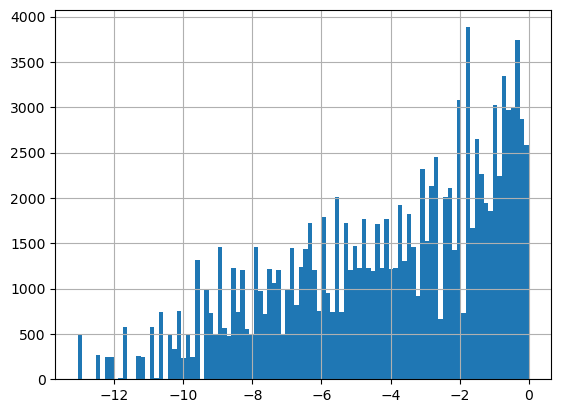

In [49]:
rewards.hist(bins=100)

In [50]:
rewards.describe()

count    120311.000000
mean         -4.106563
std           3.100551
min         -13.054898
25%          -6.376324
50%          -3.458513
75%          -1.436583
max           0.000000
Name: exp_reward, dtype: float64

In [51]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hid1 = torch.nn.Linear(794, 128)  
        self.hid2 = torch.nn.Linear(128, 32)
        self.oupt = torch.nn.Linear(32, 1)

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.hid2.weight)
        torch.nn.init.zeros_(self.hid2.bias)
        torch.nn.init.xavier_uniform_(self.oupt.weight)
        torch.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        z = torch.relu(self.hid1(x))
        z = torch.relu(self.hid2(z))
        z = self.oupt(z)  # no activation
        return z

In [54]:
from tqdm.notebook import tqdm
# Initialize the MLP
mlp = SimpleNet()

lr = 1e-5
n_epochs = 100
batch_size = 10

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# Define the loss function and optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
  
# Run the training loop
for epoch in range(n_epochs): 
    mlp.train()
    print('Starting epoch %d' %epoch)
    
    # Set current loss value
    current_loss = 0.0
    epoch_losses = []
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        
      # Get and prepare inputs
        inputs, targets = data
        # inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp(inputs)
      
      # Compute loss
        loss = loss_function(outputs, targets)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        if i % 100 == 0:
            current_loss = current_loss/(100*batch_size)
            epoch_losses.append(current_loss)
            #print('Loss after mini-batch %5d: %.10f' %
            #    (i + 1, current_loss))
            current_loss = 0.0
                  
    e_l_m =  np.mean(epoch_losses)
    print('Avg. loss for epoch %d %.10f' %(epoch, e_l_m))
    history.append(e_l_m)
    print('Avg. loss for all epochs at epoch %d %.10f' %(epoch, np.mean(history)))

# Process is complete.
print('Training process has finished.')

Starting epoch 0
Avg. loss for epoch 0 1.3065680779
Avg. loss for all epochs at epoch 0 1.3065680779
Starting epoch 1
Avg. loss for epoch 1 0.9613124471
Avg. loss for all epochs at epoch 1 1.1339402625
Starting epoch 2
Avg. loss for epoch 2 0.9567537006
Avg. loss for all epochs at epoch 2 1.0748780752
Starting epoch 3
Avg. loss for epoch 3 0.9543868210
Avg. loss for all epochs at epoch 3 1.0447552617
Starting epoch 4
Avg. loss for epoch 4 0.9525339427
Avg. loss for all epochs at epoch 4 1.0263109979
Starting epoch 5
Avg. loss for epoch 5 0.9515896185
Avg. loss for all epochs at epoch 5 1.0138574347
Starting epoch 6
Avg. loss for epoch 6 0.9508822131
Avg. loss for all epochs at epoch 6 1.0048609744
Starting epoch 7
Avg. loss for epoch 7 0.9501233630
Avg. loss for all epochs at epoch 7 0.9980187730
Starting epoch 8
Avg. loss for epoch 8 0.9494419241
Avg. loss for all epochs at epoch 8 0.9926213453
Starting epoch 9
Avg. loss for epoch 9 0.9490555698
Avg. loss for all epochs at epoch 9 0.9

Avg. loss for epoch 79 0.9338321698
Avg. loss for all epochs at epoch 79 0.9475602082
Starting epoch 80
Avg. loss for epoch 80 0.9339099019
Avg. loss for all epochs at epoch 80 0.9473916859
Starting epoch 81
Avg. loss for epoch 81 0.9336416333
Avg. loss for all epochs at epoch 81 0.9472240023
Starting epoch 82
Avg. loss for epoch 82 0.9333825786
Avg. loss for all epochs at epoch 82 0.9470572382
Starting epoch 83
Avg. loss for epoch 83 0.9332649932
Avg. loss for all epochs at epoch 83 0.9468930448
Starting epoch 84
Avg. loss for epoch 84 0.9328349177
Avg. loss for all epochs at epoch 84 0.9467276550
Starting epoch 85
Avg. loss for epoch 85 0.9325425671
Avg. loss for all epochs at epoch 85 0.9465627121
Starting epoch 86
Avg. loss for epoch 86 0.9318324576
Avg. loss for all epochs at epoch 86 0.9463933989
Starting epoch 87
Avg. loss for epoch 87 0.9320969252
Avg. loss for all epochs at epoch 87 0.9462309389
Starting epoch 88
Avg. loss for epoch 88 0.9316516386
Avg. loss for all epochs at 

In [55]:
mlp.eval()

SimpleNet(
  (hid1): Linear(in_features=794, out_features=128, bias=True)
  (hid2): Linear(in_features=128, out_features=32, bias=True)
  (oupt): Linear(in_features=32, out_features=1, bias=True)
)

In [56]:
batch_size = 10
testloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [57]:
losses_val = []

# Iterate over the DataLoader for training data
for i, data in enumerate(testloader, 0):
              
    # Get and prepare inputs
    inputs, targets = data
    # inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
      
    # Perform forward pass
    outputs = mlp(inputs)
      
    # Compute loss
    loss = loss_function(outputs, targets)
      
    # Print statistics
    current_loss += loss.item()
    if i % 100 == 0:
        current_loss = current_loss/(100*batch_size)
        losses_val.append(current_loss)
        current_loss = 0.0
                  
l_m_val =  np.mean(losses_val)
print('Avg. loss for all validation %.10f' %l_m_val) 


Avg. loss for all validation 0.9258092825


In [60]:
batch_size = 1
testloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
# Iterate over the DataLoader for training data
for i, data in enumerate(testloader, 0):
              
    # Get and prepare inputs
    inputs, targets = data
    # inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
      
    # Perform forward pass
    outputs = mlp(inputs)
      
    # Compute loss
    loss = loss_function(outputs, targets)
    print('Target: %.3f --- Output: %.3f --- Loss: %.3f' % (targets, outputs, loss))

Target: -4.950 --- Output: -4.173 --- Loss: 0.604
Target: -3.960 --- Output: -4.579 --- Loss: 0.383
Target: -0.782 --- Output: -4.236 --- Loss: 11.931
Target: -2.726 --- Output: -4.190 --- Loss: 2.143
Target: -0.277 --- Output: -4.659 --- Loss: 19.198
Target: -4.709 --- Output: -4.031 --- Loss: 0.459
Target: -0.505 --- Output: -4.021 --- Loss: 12.358
Target: -8.237 --- Output: -3.664 --- Loss: 20.913
Target: -9.636 --- Output: -3.832 --- Loss: 33.695
Target: -1.804 --- Output: -4.099 --- Loss: 5.269
Target: -4.121 --- Output: -4.675 --- Loss: 0.307
Target: -0.330 --- Output: -3.750 --- Loss: 11.698
Target: -7.747 --- Output: -4.116 --- Loss: 13.186
Target: -3.756 --- Output: -4.295 --- Loss: 0.290
Target: -2.277 --- Output: -4.321 --- Loss: 4.179
Target: -0.635 --- Output: -4.277 --- Loss: 13.266
Target: -8.911 --- Output: -4.388 --- Loss: 20.455
Target: -0.342 --- Output: -4.004 --- Loss: 13.410
Target: -6.854 --- Output: -3.821 --- Loss: 9.196
Target: -1.330 --- Output: -4.256 --- Lo

Target: -2.200 --- Output: -4.434 --- Loss: 4.992
Target: 0.000 --- Output: -3.660 --- Loss: 13.392
Target: -4.950 --- Output: -4.342 --- Loss: 0.370
Target: -0.990 --- Output: -4.250 --- Loss: 10.629
Target: -4.735 --- Output: -3.929 --- Loss: 0.650
Target: -4.721 --- Output: -4.228 --- Loss: 0.242
Target: -4.482 --- Output: -4.505 --- Loss: 0.001
Target: -4.415 --- Output: -4.380 --- Loss: 0.001
Target: -0.988 --- Output: -4.145 --- Loss: 9.969
Target: -1.673 --- Output: -4.272 --- Loss: 6.755
Target: 0.000 --- Output: -4.684 --- Loss: 21.939
Target: -0.332 --- Output: -3.668 --- Loss: 11.131
Target: -10.355 --- Output: -4.460 --- Loss: 34.754
Target: -1.177 --- Output: -4.092 --- Loss: 8.497
Target: -4.121 --- Output: -3.972 --- Loss: 0.022
Target: -3.259 --- Output: -4.141 --- Loss: 0.778
Target: -1.980 --- Output: -4.099 --- Loss: 4.489
Target: -7.475 --- Output: -4.777 --- Loss: 7.279
Target: -6.253 --- Output: -4.511 --- Loss: 3.035
Target: -1.437 --- Output: -3.430 --- Loss: 3.

Target: -1.803 --- Output: -4.141 --- Loss: 5.467
Target: -4.139 --- Output: -4.289 --- Loss: 0.022
Target: -3.630 --- Output: -3.985 --- Loss: 0.126
Target: -7.188 --- Output: -4.314 --- Loss: 8.256
Target: -2.666 --- Output: -3.624 --- Loss: 0.917
Target: -5.826 --- Output: -3.856 --- Loss: 3.881
Target: -10.965 --- Output: -4.101 --- Loss: 47.119
Target: -4.788 --- Output: -4.210 --- Loss: 0.334
Target: -2.286 --- Output: -4.587 --- Loss: 5.292
Target: -0.440 --- Output: -3.375 --- Loss: 8.612
Target: -1.490 --- Output: -4.047 --- Loss: 6.535
Target: -4.190 --- Output: -4.702 --- Loss: 0.263
Target: -5.329 --- Output: -4.546 --- Loss: 0.613
Target: -1.074 --- Output: -4.254 --- Loss: 10.113
Target: -3.084 --- Output: -4.349 --- Loss: 1.599
Target: -7.353 --- Output: -4.482 --- Loss: 8.240
Target: -12.237 --- Output: -3.753 --- Loss: 71.976
Target: -0.525 --- Output: -3.889 --- Loss: 11.323
Target: -7.297 --- Output: -3.943 --- Loss: 11.249
Target: -6.854 --- Output: -4.480 --- Loss:

Target: -8.724 --- Output: -4.565 --- Loss: 17.298
Target: -3.341 --- Output: -4.589 --- Loss: 1.557
Target: -6.854 --- Output: -4.018 --- Loss: 8.040
Target: -1.955 --- Output: -4.029 --- Loss: 4.301
Target: -9.240 --- Output: -4.322 --- Loss: 24.186
Target: -2.344 --- Output: -4.253 --- Loss: 3.644
Target: -3.756 --- Output: -4.229 --- Loss: 0.224
Target: -4.278 --- Output: -4.508 --- Loss: 0.053
Target: -0.714 --- Output: -3.656 --- Loss: 8.653
Target: -1.611 --- Output: -3.875 --- Loss: 5.126
Target: -2.649 --- Output: -4.250 --- Loss: 2.563
Target: -3.300 --- Output: -4.060 --- Loss: 0.578
Target: -2.420 --- Output: -3.494 --- Loss: 1.153
Target: -1.678 --- Output: -4.740 --- Loss: 9.380
Target: -0.882 --- Output: -3.776 --- Loss: 8.376
Target: -3.048 --- Output: -4.549 --- Loss: 2.253
Target: -1.825 --- Output: -4.404 --- Loss: 6.649
Target: -5.280 --- Output: -3.874 --- Loss: 1.976
Target: -7.188 --- Output: -3.680 --- Loss: 12.303
Target: -0.189 --- Output: -3.239 --- Loss: 9.3

Target: -4.176 --- Output: -4.007 --- Loss: 0.029
Target: -2.742 --- Output: -4.449 --- Loss: 2.913
Target: -5.500 --- Output: -4.269 --- Loss: 1.515
Target: -1.621 --- Output: -4.147 --- Loss: 6.379
Target: -3.461 --- Output: -4.032 --- Loss: 0.326
Target: -0.518 --- Output: -4.234 --- Loss: 13.807
Target: 0.000 --- Output: -4.491 --- Loss: 20.172
Target: -8.515 --- Output: -4.569 --- Loss: 15.568
Target: -2.625 --- Output: -4.194 --- Loss: 2.460
Target: -1.037 --- Output: -4.327 --- Loss: 10.823
Target: -8.974 --- Output: -4.494 --- Loss: 20.071
Target: -6.600 --- Output: -3.611 --- Loss: 8.932
Target: -3.070 --- Output: -4.059 --- Loss: 0.977
Target: -8.931 --- Output: -3.795 --- Loss: 26.372
Target: -4.415 --- Output: -4.386 --- Loss: 0.001
Target: -3.773 --- Output: -3.997 --- Loss: 0.050
Target: -3.593 --- Output: -3.910 --- Loss: 0.101
Target: -4.475 --- Output: -4.060 --- Loss: 0.172
Target: -5.904 --- Output: -4.300 --- Loss: 2.573
Target: -5.592 --- Output: -4.120 --- Loss: 2

Target: 0.000 --- Output: -4.219 --- Loss: 17.804
Target: -0.259 --- Output: -4.783 --- Loss: 20.467
Target: -7.932 --- Output: -4.147 --- Loss: 14.330
Target: -0.554 --- Output: -4.423 --- Loss: 14.966
Target: -2.666 --- Output: -3.704 --- Loss: 1.078
Target: -0.495 --- Output: -4.533 --- Loss: 16.303
Target: -5.329 --- Output: -4.158 --- Loss: 1.372
Target: -1.650 --- Output: -4.416 --- Loss: 7.649
Target: -0.967 --- Output: -4.678 --- Loss: 13.771
Target: -12.237 --- Output: -4.412 --- Loss: 61.225
Target: -6.138 --- Output: -4.331 --- Loss: 3.264
Target: -2.323 --- Output: -4.412 --- Loss: 4.363
Target: -7.824 --- Output: -4.584 --- Loss: 10.499
Target: -0.988 --- Output: -3.957 --- Loss: 8.815
Target: -4.180 --- Output: -4.353 --- Loss: 0.030
Target: -7.648 --- Output: -4.383 --- Loss: 10.661
Target: -6.753 --- Output: -5.338 --- Loss: 2.001
Target: -6.350 --- Output: -4.398 --- Loss: 3.811
Target: -5.079 --- Output: -4.335 --- Loss: 0.554
Target: -0.600 --- Output: -4.546 --- Los

Target: -3.863 --- Output: -4.092 --- Loss: 0.052
Target: -5.940 --- Output: -4.050 --- Loss: 3.571
Target: -4.159 --- Output: -3.671 --- Loss: 0.239
Target: -11.168 --- Output: -4.055 --- Loss: 50.598
Target: -1.371 --- Output: -3.983 --- Loss: 6.821
Target: -4.693 --- Output: -4.264 --- Loss: 0.184
Target: -4.413 --- Output: -4.026 --- Loss: 0.150
Target: -6.890 --- Output: -4.101 --- Loss: 7.778
Target: -1.020 --- Output: -4.380 --- Loss: 11.289
Target: -3.740 --- Output: -4.413 --- Loss: 0.452
Target: -1.540 --- Output: -4.306 --- Loss: 7.652
Target: -5.240 --- Output: -4.384 --- Loss: 0.734
Target: -6.511 --- Output: -4.144 --- Loss: 5.603
Target: -7.791 --- Output: -4.213 --- Loss: 12.800
Target: -1.087 --- Output: -4.510 --- Loss: 11.721
Target: -5.446 --- Output: -4.169 --- Loss: 1.630
Target: -5.206 --- Output: -4.236 --- Loss: 0.941
Target: -7.648 --- Output: -3.874 --- Loss: 14.246
Target: -4.789 --- Output: -4.190 --- Loss: 0.358
Target: -3.084 --- Output: -4.188 --- Loss: 

Target: -5.940 --- Output: -4.299 --- Loss: 2.694
Target: -5.904 --- Output: -4.143 --- Loss: 3.103
Target: -7.340 --- Output: -4.439 --- Loss: 8.416
Target: -8.392 --- Output: -4.365 --- Loss: 16.221
Target: -7.300 --- Output: -4.202 --- Loss: 9.601
Target: -5.298 --- Output: -4.600 --- Loss: 0.487
Target: -3.070 --- Output: -4.509 --- Loss: 2.068
Target: -7.121 --- Output: -4.523 --- Loss: 6.751
Target: -1.714 --- Output: -3.966 --- Loss: 5.071
Target: -11.334 --- Output: -4.177 --- Loss: 51.223
Target: -0.104 --- Output: -4.669 --- Loss: 20.840
Target: -1.766 --- Output: -3.884 --- Loss: 4.485
Target: -2.345 --- Output: -4.184 --- Loss: 3.385
Target: -1.766 --- Output: -4.119 --- Loss: 5.537
Target: -1.177 --- Output: -4.379 --- Loss: 10.250
Target: -5.600 --- Output: -4.100 --- Loss: 2.248
Target: -3.153 --- Output: -3.610 --- Loss: 0.209
Target: -1.328 --- Output: -4.508 --- Loss: 10.113
Target: -3.773 --- Output: -4.083 --- Loss: 0.096
Target: -6.253 --- Output: -4.182 --- Loss: 

Target: -1.548 --- Output: -4.256 --- Loss: 7.338
Target: -1.134 --- Output: -4.641 --- Loss: 12.301
Target: -6.160 --- Output: -4.046 --- Loss: 4.469
Target: -5.720 --- Output: -4.594 --- Loss: 1.268
Target: -8.365 --- Output: -4.446 --- Loss: 15.359
Target: -2.726 --- Output: -3.861 --- Loss: 1.287
Target: -2.080 --- Output: -4.365 --- Loss: 5.220
Target: -2.726 --- Output: -4.267 --- Loss: 2.373
Target: -5.079 --- Output: -3.855 --- Loss: 1.500
Target: -7.297 --- Output: -4.244 --- Loss: 9.320
Target: -5.206 --- Output: -4.483 --- Loss: 0.524
Target: -2.042 --- Output: -3.653 --- Loss: 2.596
Target: -2.400 --- Output: -3.866 --- Loss: 2.149
Target: -1.170 --- Output: -3.728 --- Loss: 6.542
Target: -5.004 --- Output: -3.981 --- Loss: 1.046
Target: -1.838 --- Output: -4.695 --- Loss: 8.162
Target: -1.673 --- Output: -4.554 --- Loss: 8.302
Target: -5.826 --- Output: -4.165 --- Loss: 2.759
Target: -5.500 --- Output: -3.660 --- Loss: 3.387
Target: -2.042 --- Output: -4.138 --- Loss: 4.39

Target: -2.752 --- Output: -3.973 --- Loss: 1.491
Target: -4.868 --- Output: -3.858 --- Loss: 1.020
Target: -5.785 --- Output: -4.322 --- Loss: 2.141
Target: -11.168 --- Output: -4.022 --- Loss: 51.058
Target: -4.693 --- Output: -3.960 --- Loss: 0.537
Target: -1.020 --- Output: -4.389 --- Loss: 11.345
Target: -9.533 --- Output: -3.750 --- Loss: 33.444
Target: -2.449 --- Output: -4.354 --- Loss: 3.628
Target: -2.326 --- Output: -3.835 --- Loss: 2.275
Target: -6.017 --- Output: -4.423 --- Loss: 2.540
Target: -0.635 --- Output: -5.396 --- Loss: 22.667
Target: -0.294 --- Output: -3.964 --- Loss: 13.465
Target: -6.241 --- Output: -4.955 --- Loss: 1.654
Target: -1.074 --- Output: -4.173 --- Loss: 9.608
Target: -1.165 --- Output: -4.206 --- Loss: 9.248
Target: -2.860 --- Output: -4.335 --- Loss: 2.175
Target: -3.034 --- Output: -4.207 --- Loss: 1.376
Target: -3.223 --- Output: -4.131 --- Loss: 0.825
Target: -2.943 --- Output: -3.633 --- Loss: 0.476
Target: -1.177 --- Output: -4.421 --- Loss: 

Target: -6.380 --- Output: -4.096 --- Loss: 5.215
Target: -2.815 --- Output: -3.994 --- Loss: 1.391
Target: -0.928 --- Output: -4.202 --- Loss: 10.722
Target: -3.080 --- Output: -4.069 --- Loss: 0.979
Target: -0.495 --- Output: -3.964 --- Loss: 12.031
Target: -5.240 --- Output: -4.383 --- Loss: 0.735
Target: -8.340 --- Output: -4.574 --- Loss: 14.188
Target: -0.551 --- Output: -4.195 --- Loss: 13.276
Target: -3.764 --- Output: -4.105 --- Loss: 0.117
Target: -9.570 --- Output: -3.888 --- Loss: 32.283
Target: -0.417 --- Output: -4.436 --- Loss: 16.156
Target: -1.548 --- Output: -4.267 --- Loss: 7.396
Target: -0.782 --- Output: -4.522 --- Loss: 13.995
Target: -1.621 --- Output: -4.041 --- Loss: 5.858
Target: -0.606 --- Output: -3.766 --- Loss: 9.985
Target: -3.034 --- Output: -4.489 --- Loss: 2.119
Target: -12.237 --- Output: -4.314 --- Loss: 62.771
Target: -5.610 --- Output: -3.967 --- Loss: 2.701
Target: -7.791 --- Output: -4.741 --- Loss: 9.300
Target: -3.574 --- Output: -4.222 --- Los

Target: -1.308 --- Output: -3.968 --- Loss: 7.074
Target: -0.488 --- Output: -3.913 --- Loss: 11.732
Target: -1.798 --- Output: -3.689 --- Loss: 3.575
Target: -6.253 --- Output: -4.123 --- Loss: 4.538
Target: -3.226 --- Output: -4.232 --- Loss: 1.012
Target: -5.974 --- Output: -4.354 --- Loss: 2.624
Target: -7.260 --- Output: -3.988 --- Loss: 10.704
Target: -2.649 --- Output: -4.115 --- Loss: 2.151
Target: -3.863 --- Output: -3.889 --- Loss: 0.001
Target: -0.928 --- Output: -4.561 --- Loss: 13.203
Target: -1.296 --- Output: -4.244 --- Loss: 8.694
Target: -5.298 --- Output: -4.826 --- Loss: 0.223
Target: -8.392 --- Output: -4.383 --- Loss: 16.071
Target: -8.125 --- Output: -3.999 --- Loss: 17.026
Target: -0.952 --- Output: -4.571 --- Loss: 13.099
Target: -3.428 --- Output: -4.202 --- Loss: 0.599
Target: -9.984 --- Output: -3.932 --- Loss: 36.629
Target: -2.042 --- Output: -3.757 --- Loss: 2.941
Target: -5.547 --- Output: -4.296 --- Loss: 1.564
Target: -3.600 --- Output: -4.156 --- Loss:

Target: -2.344 --- Output: -4.067 --- Loss: 2.968
Target: -4.112 --- Output: -3.614 --- Loss: 0.249
Target: -1.448 --- Output: -3.825 --- Loss: 5.649
Target: -4.967 --- Output: -4.231 --- Loss: 0.541
Target: -10.664 --- Output: -4.344 --- Loss: 39.931
Target: -3.265 --- Output: -4.215 --- Loss: 0.902
Target: -10.364 --- Output: -4.368 --- Loss: 35.958
Target: -4.455 --- Output: -4.636 --- Loss: 0.033
Target: -8.194 --- Output: -4.372 --- Loss: 14.613
Target: -6.385 --- Output: -4.133 --- Loss: 5.074
Target: -5.446 --- Output: -3.629 --- Loss: 3.300
Target: -9.636 --- Output: -4.224 --- Loss: 29.290
Target: -9.355 --- Output: -4.187 --- Loss: 26.705
Target: -7.349 --- Output: -4.308 --- Loss: 9.245
Target: -9.287 --- Output: -4.089 --- Loss: 27.010
Target: -5.280 --- Output: -4.091 --- Loss: 1.414
Target: -5.881 --- Output: -3.999 --- Loss: 3.542
Target: -0.476 --- Output: -3.991 --- Loss: 12.352
Target: -7.380 --- Output: -4.046 --- Loss: 11.111
Target: -5.720 --- Output: -4.263 --- Lo

In [99]:
losses = []
outputs_all = []
targets_all = []
for i,data in enumerate(testloader):
    # Get and prepare inputs
    inputs, targets = data
    # inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
      
    # Perform forward pass
    outputs = mlp(inputs)
    outputs_all.append(outputs[0].detach().numpy())
    targets_all.append(targets[0].detach().numpy())
      
    # Compute loss
    loss = loss_function(outputs, targets)
    if targets >= -0.01:
        losses.append(loss.detach().numpy())
        print("Outputs %.10f" %outputs)
        print("Target %.10f" %targets)
        print("Loss %.10f" %loss)
        print("---------------------------")
    
print("Avg. Loss for targets >= -0.01: %.10f" %np.mean(losses))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

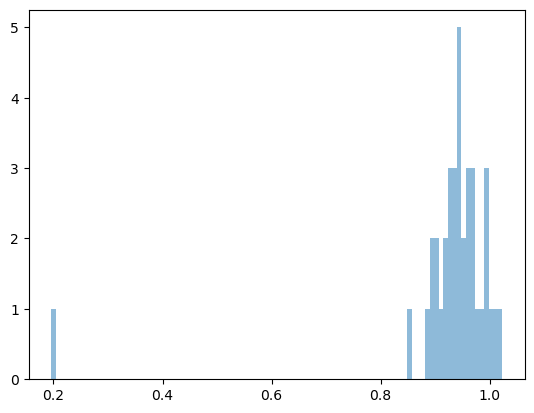

In [58]:
plt.hist(losses_val, bins=100, alpha=0.5)
plt.show()

In [59]:
from sklearn.metrics import r2_score

print(r2_score(outputs_all, targets_all))


NameError: name 'outputs_all' is not defined